In [ ]:
%pip install grad-cam

#### Now we are going to apply eigen cam on YOLO v5 model. There are certain things that we must consider before beginning with creation of the code for the interpretation of the model

- **The reshape transform - This isnt necessary for this model since it directly will return 2D spatial tensor as it's output.**

- **The target function - For eigen cam there won't be a a target function necessary for this, instead we will just apply PCA on the 2D activations**

- **The target layer - We will be extracting the second last layer as the target layer since the final layer just deals with the detections.**

In [3]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import torch    
import cv2
import numpy as np
import requests
import torchvision.transforms as transforms
from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_cam_image
from PIL import Image

In [5]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
requirements: YOLOv5 requirement "setuptools>=65.5.1" not found, attempting AutoUpdate...
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
tensorflow-serving-api 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
librosa 0.10.0.post2 requires soundfile>=0.12.1, but you have soundfile 0.11.0 which is incompatible.
cloud-tpu-client 0.10 requires google-api-python-client==1.8.0, but you have google-api-python-client 2.83.0 which is incompatible.
  Using cached setuptools-67.6.1-py3-none-any.whl (1.1 MB)
  Attempting uninstall: setuptools
    Found existing installation: setuptools 59.8.0
    Uninstalling setuptools-59.8.0:

  0%|          | 0.00/14.1M [00:00<?, ?B/s]


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


#### After playing with the model, we can find the second last layer in it

In [ ]:
for modules in model.named_children():
    print(modules)

In [30]:
print(type(model))
print(type(model.model))
print(type(model.model.model))
print(type(model.model.model.model))
print(model.model.model.model[-2])

<class 'models.common.AutoShape'>
<class 'models.common.DetectMultiBackend'>
<class 'models.yolo.DetectionModel'>
<class 'torch.nn.modules.container.Sequential'>
C3(
  (cv1): Conv(
    (conv): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (act): SiLU(inplace=True)
  )
  (cv2): Conv(
    (conv): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (act): SiLU(inplace=True)
  )
  (cv3): Conv(
    (conv): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
    (act): SiLU(inplace=True)
  )
  (m): Sequential(
    (0): Bottleneck(
      (cv1): Conv(
        (conv): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
    )
  )
)


In [35]:
import io

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
requirements: YOLOv5 requirement "setuptools>=65.5.1" not found, attempting AutoUpdate...

requirements: 1 package updated per /root/.cache/torch/hub/ultralytics_yolov5_master/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 2023-4-12 Python-3.7.12 torch-1.13.0+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


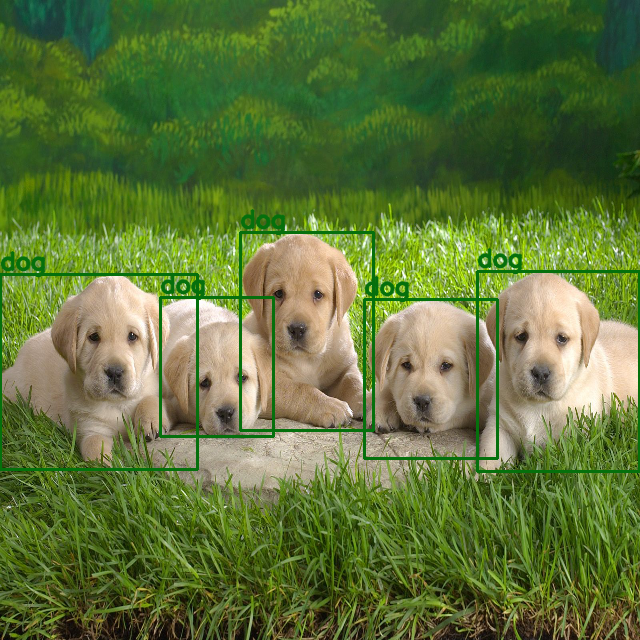

In [41]:
COLORS = np.random.uniform(0, 255, size=(80, 3))

def parse_detections(results):
    detections = results.pandas().xyxy[0]
    detections = detections.to_dict()
    boxes, colors, names = [], [], []

    for i in range(len(detections["xmin"])):
        confidence = detections["confidence"][i]
        if confidence < 0.2:
            continue
        xmin = int(detections["xmin"][i])
        ymin = int(detections["ymin"][i])
        xmax = int(detections["xmax"][i])
        ymax = int(detections["ymax"][i])
        name = detections["name"][i]
        category = int(detections["class"][i])
        color = COLORS[category]

        boxes.append((xmin, ymin, xmax, ymax))
        colors.append(color)
        names.append(name)
    return boxes, colors, names


def draw_detections(boxes, colors, names, img):
    for box, color, name in zip(boxes, colors, names):
        xmin, ymin, xmax, ymax = box
        cv2.rectangle(
            img,
            (xmin, ymin),
            (xmax, ymax),
            color, 
            2)

        cv2.putText(img, name, (xmin, ymin - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2,
                    lineType=cv2.LINE_AA)
    return img

headers = {'User-Agent' : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/112.0.0.0 Safari/537.36' }
image_url = "https://upload.wikimedia.org/wikipedia/commons/f/f1/Puppies_%284984818141%29.jpg"
response = requests.get(image_url, stream=True, headers = headers)
img = np.array(Image.open(io.BytesIO(response.content)))
img = cv2.resize(img, (640, 640))
rgb_img = img.copy()
img = np.float32(img) / 255
transform = transforms.ToTensor()
tensor = transform(img).unsqueeze(0)

model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
model.eval()
model.cpu()
target_layers = [model.model.model.model[-2]]

results = model([rgb_img])
boxes, colors, names = parse_detections(results)
detections = draw_detections(boxes, colors, names, rgb_img.copy())
Image.fromarray(detections)

#### Creating the cam model and running it on the image.

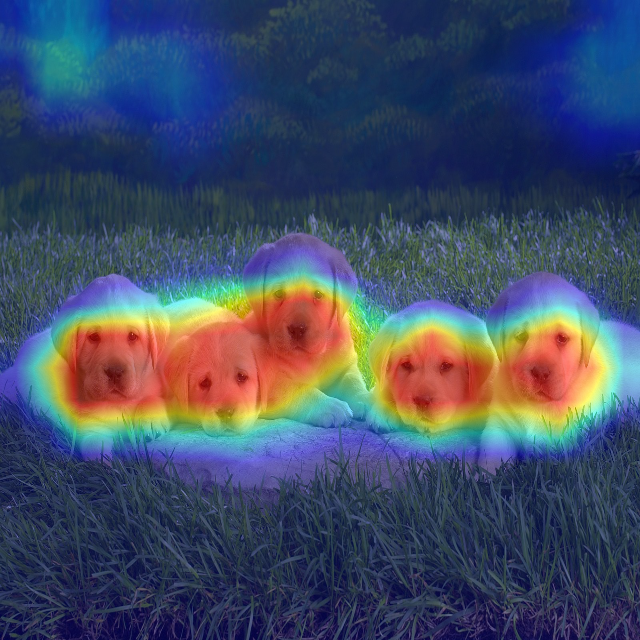

In [42]:
cam = EigenCAM(model, target_layers, use_cuda=False)
grayscale_cam = cam(tensor)[0, :, :]
cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
Image.fromarray(cam_image)

#### We can also remove the heatmap data outside the bounding boxes and scale them inside every bounding box

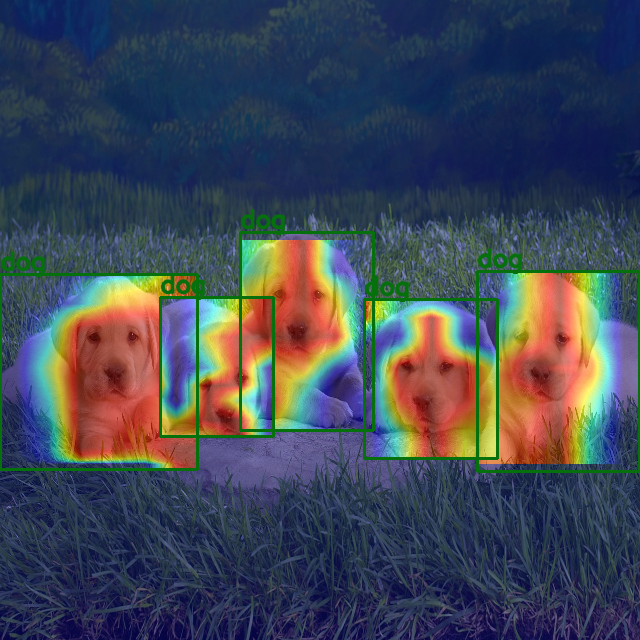

In [43]:
def renormalize_cam_in_bounding_boxes(boxes, colors, names, image_float_np, grayscale_cam):
    """Normalize the CAM to be in the range [0, 1] 
    inside every bounding boxes, and zero outside of the bounding boxes. """
    renormalized_cam = np.zeros(grayscale_cam.shape, dtype=np.float32)
    for x1, y1, x2, y2 in boxes:
        renormalized_cam[y1:y2, x1:x2] = scale_cam_image(grayscale_cam[y1:y2, x1:x2].copy())    
    renormalized_cam = scale_cam_image(renormalized_cam)
    eigencam_image_renormalized = show_cam_on_image(image_float_np, renormalized_cam, use_rgb=True)
    image_with_bounding_boxes = draw_detections(boxes, colors, names, eigencam_image_renormalized)
    return image_with_bounding_boxes


renormalized_cam_image = renormalize_cam_in_bounding_boxes(boxes, colors, names, img, grayscale_cam)
Image.fromarray(renormalized_cam_image)

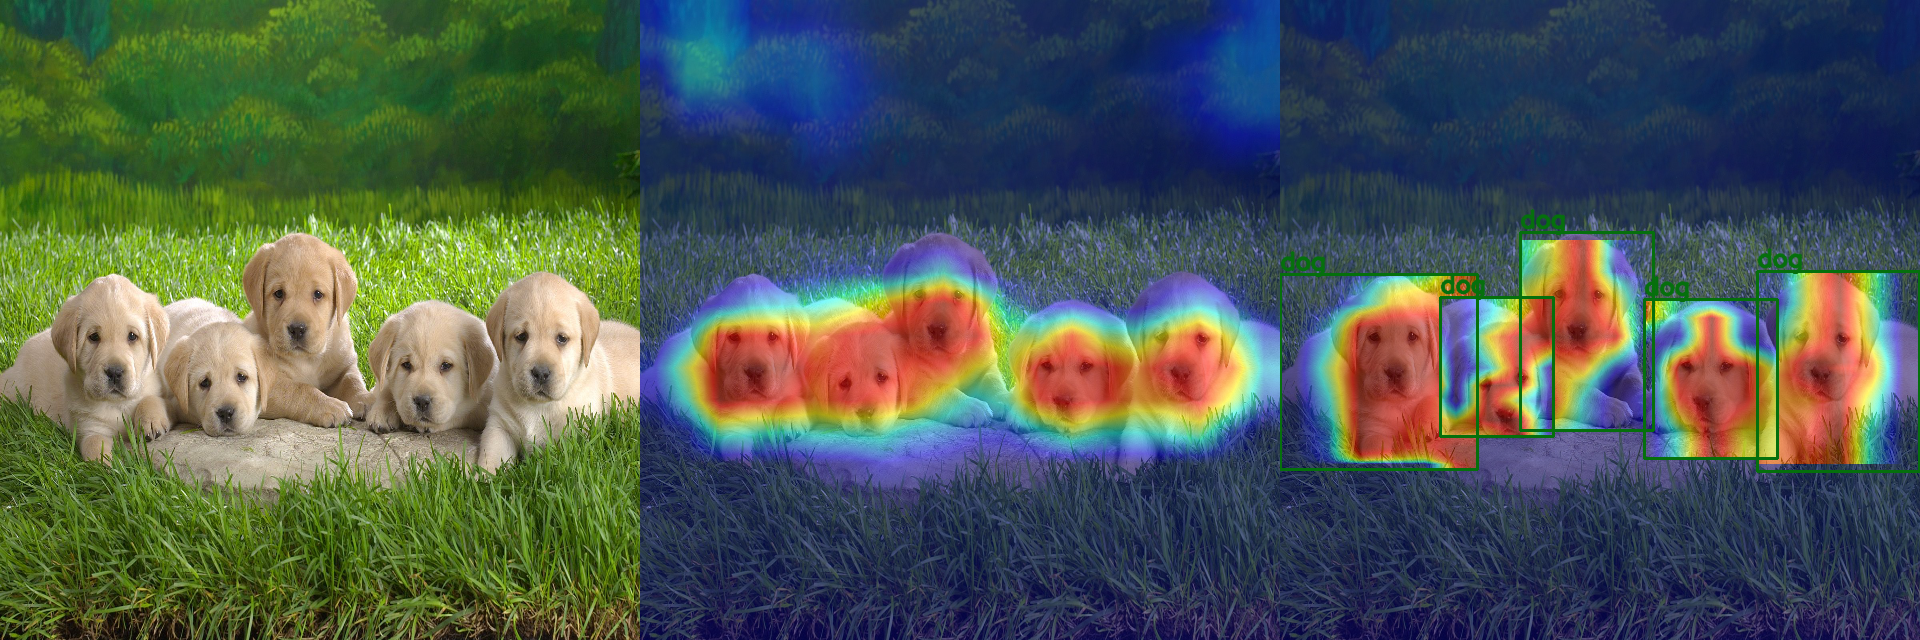

In [44]:
Image.fromarray(np.hstack((rgb_img, cam_image, renormalized_cam_image)))